<a id=contents></a>

# Latent Dirichlet Allocation on Web-scraped data

## Finding topics from raw data



In [24]:
import pandas as pd
import numpy as np
load_dotenv()
import time

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
import string

from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')
stop_words = list(set(stopwords.words("english")))
stop_words += list(string.punctuation)

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD as LSA
      
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

import functions as fn
import topic_mod as topic


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id=prev ><a/> 

## 1. Most prevalent words
    

In [60]:
df = pd.read_csv('jobs.csv', index_col=0)

In [26]:
stop_words = fn.gen_stopwords(['data', 'scientist', 'machine', 'analyst'])

In [38]:
%%time

number_topics = 10

count_vect_lem = CountVectorizer(tokenizer=fn.LemmaTokenizer(tokenizer, stop_words),
                       strip_accents = 'unicode',
                       stop_words = stop_words,
                       lowercase = True,)

lda = LDA(n_components=number_topics,
          doc_topic_prior = 1,
          topic_word_prior = 0.05,
          n_jobs=-1, random_state=12345)



lda_data, lda_obj = topic.data_to_lda(df, 13, 'job_descr', count_vect_lem, lda, )

number_words = 30

# Print the topics found by the LDA model
print("Topics found via LDA on Count Vectorised data for ALL categories:")
topic.print_topics(lda_obj, count_vect_lem, number_words)

Topics found via LDA on Count Vectorised data for ALL categories:

Topic #0:
software; experience; amazon; learning; opportunity; team; application; business; work; product; engineer; problem; development; technical; make; personal; process; skill; working; science; system; environment; algorithm; ability; offer; platform; build; solution; technology; engineering

Topic #1:
learning; research; experience; science; team; role; work; working; model; skill; deep; please; language; python; nlp; quantitative; technique; candidate; algorithm; researcher; statistic; london; using; world; new; service; processing; problem; development; phd

Topic #2:
learning; work; team; time; company; causalens; business; high; platform; exciting; award; day; development; approach; best; holiday; fund; mission; opportunity; problem; scheme; experience; product; end; full; role; smart; including; series; fast

Topic #3:
client; business; team; work; people; opportunity; service; financial; role; value; invest

## 2. Visualising with pyLDAvis

In [57]:
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook(local=False)

In [58]:
pyLDAvis.sklearn.prepare(lda_obj, 
                         count_vect_lem.fit_transform(df['job_descr']),
                        count_vect_lem)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.099968  0.049520       1        1  16.081291
5     -0.010539  0.040324       2        1  13.334740
3     -0.090372  0.059524       3        1  13.069902
4     -0.015140 -0.017157       4        1  11.979113
8     -0.126397  0.091276       5        1  11.123056
1      0.017253 -0.065151       6        1   8.975442
6      0.051125 -0.001422       7        1   8.807087
7     -0.018395 -0.224168       8        1   6.878949
0      0.030865 -0.006562       9        1   5.129512
2      0.261567  0.073816      10        1   4.620908, topic_info=               Term         Freq        Total Category  logprob  loglift
8139       learning  3614.000000  3614.000000  Default  30.0000  30.0000
12051      research  1617.000000  1617.000000  Default  29.0000  29.0000
2989         client  2668.000000  2668.000000  Default  28.0000  28.0000
2420       business  6486.000000  6486.000000  Default  27.0000  27.0000
3565       customer  2567.000000  2567.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
7419   intelligence   124.285087   864.206447  Topic10  -5.3585   1.1353
7137      including   134.688285  1678.076848  Topic10  -5.2781   0.5521
11117       product   140.144615  3300.889404  Topic10  -5.2384  -0.0847
12325          role   135.630900  3655.764976  Topic10  -5.2712  -0.2195
5318     experience   141.009949  7824.782769  Topic10  -5.2323  -0.9416

[866 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
0          1  0.126486   000
0          2  0.010432   000
0          3  0.035208   000
0          4  0.032600   000
0          5  0.002608   000
...      ...       ...   ...
15761      6  0.127842  year
15761      7  0.242261  year
15761      8  0.052415  year
15761      9  0.040910  year
15761     10  0.016620  year

[2704 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 4, 5, 9, 2, 7, 8, 1, 3])

In [59]:
lda_data.head(2)

,company,job_title,job_descr,job_url,job_location,searched_data_analyst,searched__data_scientist,searched__machine_learning_engineer,salary_from_page_source_as_stated,salary_from_page_source_conv_hourly,...,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,Medicines and Healthcare products Regulatory A...,CPRD Data Scientist,would like reassure all applicant that recruit...,https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...,NaN,0,1,0,39853.0,21.0,...,0.035517,0.193626,0.004935,0.401131,0.026468,0.007369,0.004478,0.075060,0.154302,0.097114
1,PwC,Deals - Investigative Analytics - Data Scienti...,career within Forensics Technology service wil...,https://www.indeed.co.uk/rc/clk?jk=7548e60a487...,NaN,0,1,0,NaN,NaN,...,0.008558,0.065685,0.016643,0.563375,0.023542,0.008343,0.181735,0.006054,0.051832,0.074232


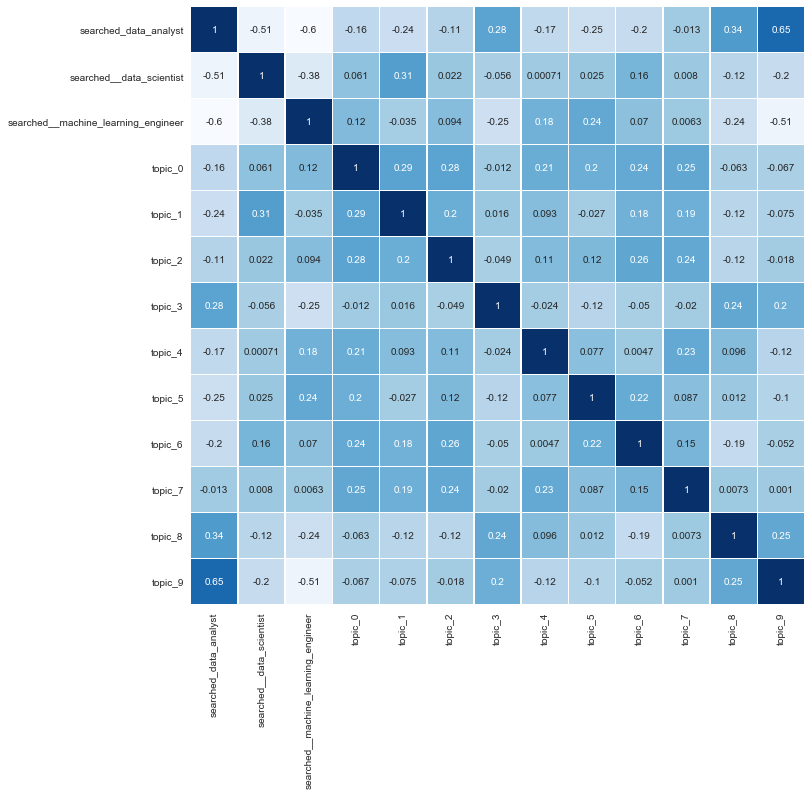

In [56]:
plt.figure(figsize=(11,11))
sns.heatmap(lda_data[['searched_data_analyst', 'searched__data_scientist', 'searched__machine_learning_engineer', 
                     'topic_0','topic_1','topic_2','topic_3','topic_4','topic_5','topic_6','topic_7','topic_8',
                     'topic_9']].corr('spearman'), annot=True, linewidths=0.5, cbar=False, cmap='Blues');